# Лабораторная 6. Семантическая сегментация

## РАБОТУ РЕКОМЕНДУЕТСЯ ВЫПОЛНЯТЬ НА GOOGLE COLAB

Инструкция по выполнению на Colab:

1. Заходим на colab.research.google.com
2. Входим в свой google-аккаунт
3. Кликаем на загрузить блокнот

![image.png](attachment:fef25653-20b0-4aab-b6aa-9a520b04e1a2.png)

4. Загружаем данный файл
5. Теперь необходимо сделать, чтобы код выполнялся на GPU, кликаем на "Изменить" и выбираем настройки блокнота, а там выбирайте T4 GPU, после сохранить

![image.png](attachment:afbb5e3f-33c1-4536-8ca6-c7953535ecec.png)

6. В левой панели с файлами будет ваша доступная файловая система, загрузите туда архив с изображениями (простыми drag-n-drop)

![image.png](attachment:32f18062-5928-4d25-a4c2-bdad48e749c9.png)

7. Используя любые пакеты Python или команды bash прямо из ноутбука распакуйте архив в ту же папку

Семантическая сегментация - задача глубокого обучения, которая состоит в том, чтобы разбить изображения на сегменты, каждый сегмент должен отделять один объект от другого по смыслу (например машину от дороги)

Для решения такой задачи чаще всего применяют сверточные нейронные сети (но некоторые архитектуры базируются и на трансформере). Архитектура такой сети имеет три уровня: энкодер, латентное пространство и декодер. Энкодер выполняет преобразование входного изображения в пространство скрытых параметров (то есть по сути выполняет сжатие данных), латентное пространство хранит в себе признаки исходного изображения. Декодер же выполняет обратное преобразование - из скрытого пространства восстанавливает изображение, которое уже поделено на сегменты

В данной работе постарайтесь получить mIoU больше 0.6 (прочитайте о такой метрике)

Можно использовать любые модели, любые методы улучшения качества, в том числе предобученные, готовый для экспериментов пайплайн представлен ниже

## Обратите внимание, что из архива с данными вам нужна ТОЛЬКО ПАПКА dataset, ее распакуйте в ту же папку, в которой лежит данный ноутбук, либо ниже указывайте полный путь к ней в переменных IMAGE_PATH и MASK_PATH

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install albumentations

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMAGE_PATH = '/content/drive/MyDrive/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/drive/MyDrive/dataset/semantic_drone_dataset/label_images_semantic/'

In [6]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [7]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


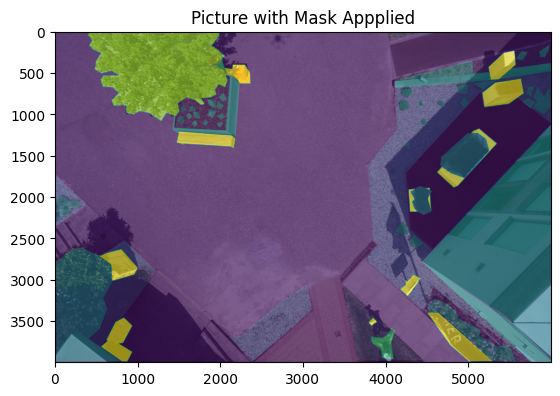

In [8]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [9]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 6

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [11]:
model = smp.FPN(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    classes=23,
    activation=None
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 240MB/s]


In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [13]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [14]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.977 
Epoch:1/30.. Train Loss: 2.478.. Val Loss: 0.977.. Train mIoU:0.086.. Val mIoU: 0.171.. Train Acc:0.458.. Val Acc:0.727.. Time: 20.42m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.977 >> 0.650 
Epoch:2/30.. Train Loss: 1.200.. Val Loss: 0.650.. Train mIoU:0.199.. Val mIoU: 0.304.. Train Acc:0.672.. Val Acc:0.805.. Time: 4.17m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.650 >> 0.626 
Epoch:3/30.. Train Loss: 0.997.. Val Loss: 0.626.. Train mIoU:0.284.. Val mIoU: 0.343.. Train Acc:0.724.. Val Acc:0.813.. Time: 4.17m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.626 >> 0.586 
saving model...
Epoch:4/30.. Train Loss: 0.784.. Val Loss: 0.586.. Train mIoU:0.335.. Val mIoU: 0.387.. Train Acc:0.774.. Val Acc:0.822.. Time: 4.21m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/30.. Train Loss: 1.070.. Val Loss: 0.879.. Train mIoU:0.285.. Val mIoU: 0.285.. Train Acc:0.704.. Val Acc:0.763.. Time: 4.21m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/30.. Train Loss: 1.083.. Val Loss: 0.987.. Train mIoU:0.271.. Val mIoU: 0.255.. Train Acc:0.696.. Val Acc:0.723.. Time: 4.24m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.987 >> 0.828 
Epoch:7/30.. Train Loss: 0.990.. Val Loss: 0.828.. Train mIoU:0.301.. Val mIoU: 0.269.. Train Acc:0.713.. Val Acc:0.770.. Time: 4.22m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.828 >> 0.694 
Epoch:8/30.. Train Loss: 0.899.. Val Loss: 0.694.. Train mIoU:0.313.. Val mIoU: 0.323.. Train Acc:0.741.. Val Acc:0.790.. Time: 4.14m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.694 >> 0.659 
Epoch:9/30.. Train Loss: 0.767.. Val Loss: 0.659.. Train mIoU:0.358.. Val mIoU: 0.359.. Train Acc:0.770.. Val Acc:0.800.. Time: 4.07m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.659 >> 0.536 
Epoch:10/30.. Train Loss: 0.779.. Val Loss: 0.536.. Train mIoU:0.350.. Val mIoU: 0.412.. Train Acc:0.769.. Val Acc:0.830.. Time: 4.11m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.536 >> 0.459 
saving model...
Epoch:11/30.. Train Loss: 0.640.. Val Loss: 0.459.. Train mIoU:0.395.. Val mIoU: 0.428.. Train Acc:0.808.. Val Acc:0.857.. Time: 4.12m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.459 >> 0.407 
Epoch:12/30.. Train Loss: 0.539.. Val Loss: 0.407.. Train mIoU:0.430.. Val mIoU: 0.460.. Train Acc:0.834.. Val Acc:0.873.. Time: 4.12m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.407 >> 0.388 
Epoch:13/30.. Train Loss: 0.505.. Val Loss: 0.388.. Train mIoU:0.450.. Val mIoU: 0.472.. Train Acc:0.842.. Val Acc:0.876.. Time: 4.15m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:14/30.. Train Loss: 0.457.. Val Loss: 0.404.. Train mIoU:0.472.. Val mIoU: 0.482.. Train Acc:0.857.. Val Acc:0.875.. Time: 4.12m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/30.. Train Loss: 0.549.. Val Loss: 0.436.. Train mIoU:0.448.. Val mIoU: 0.453.. Train Acc:0.833.. Val Acc:0.861.. Time: 4.16m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.436 >> 0.381 
Epoch:16/30.. Train Loss: 0.444.. Val Loss: 0.381.. Train mIoU:0.483.. Val mIoU: 0.475.. Train Acc:0.861.. Val Acc:0.876.. Time: 4.17m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:17/30.. Train Loss: 0.452.. Val Loss: 0.405.. Train mIoU:0.480.. Val mIoU: 0.500.. Train Acc:0.861.. Val Acc:0.875.. Time: 4.11m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.405 >> 0.352 
Epoch:18/30.. Train Loss: 0.384.. Val Loss: 0.352.. Train mIoU:0.513.. Val mIoU: 0.515.. Train Acc:0.877.. Val Acc:0.886.. Time: 4.06m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.352 >> 0.330 
saving model...
Epoch:19/30.. Train Loss: 0.356.. Val Loss: 0.330.. Train mIoU:0.533.. Val mIoU: 0.536.. Train Acc:0.886.. Val Acc:0.893.. Time: 4.03m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.330 >> 0.326 
Epoch:20/30.. Train Loss: 0.336.. Val Loss: 0.326.. Train mIoU:0.544.. Val mIoU: 0.549.. Train Acc:0.891.. Val Acc:0.896.. Time: 4.05m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.326 >> 0.311 
Epoch:21/30.. Train Loss: 0.323.. Val Loss: 0.311.. Train mIoU:0.556.. Val mIoU: 0.546.. Train Acc:0.895.. Val Acc:0.902.. Time: 4.03m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:22/30.. Train Loss: 0.318.. Val Loss: 0.319.. Train mIoU:0.555.. Val mIoU: 0.546.. Train Acc:0.895.. Val Acc:0.897.. Time: 4.01m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.319 >> 0.300 
Epoch:23/30.. Train Loss: 0.303.. Val Loss: 0.300.. Train mIoU:0.568.. Val mIoU: 0.557.. Train Acc:0.901.. Val Acc:0.902.. Time: 4.05m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.300 >> 0.287 
Epoch:24/30.. Train Loss: 0.290.. Val Loss: 0.287.. Train mIoU:0.577.. Val mIoU: 0.556.. Train Acc:0.904.. Val Acc:0.905.. Time: 4.05m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 119.22 m


In [15]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

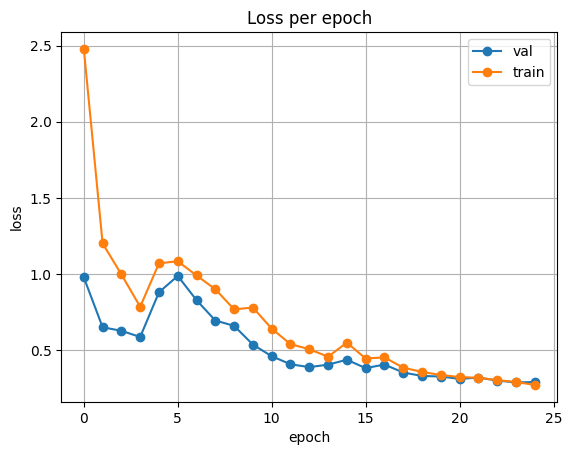

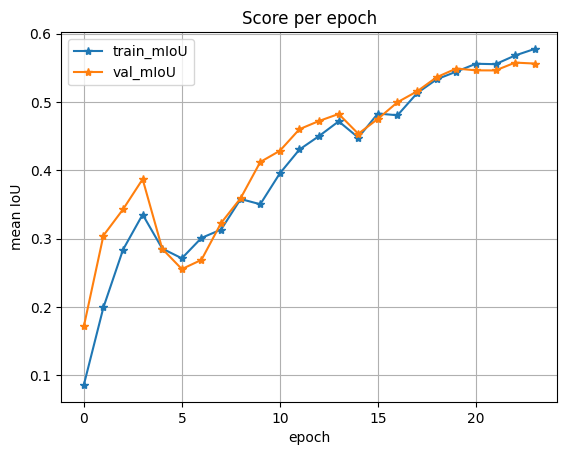

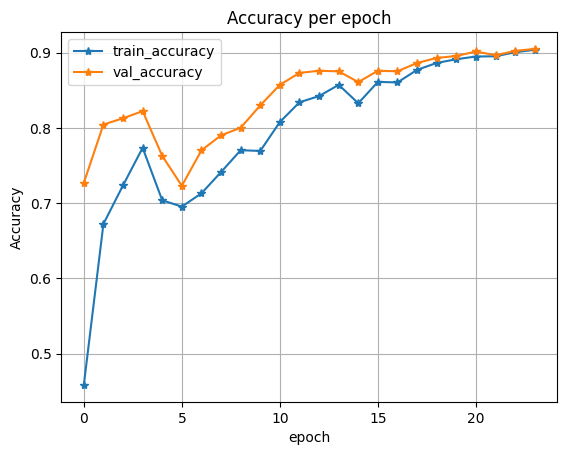

In [16]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [17]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


In [18]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [19]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [20]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [21]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

mob_miou = miou_score(model, test_set)
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

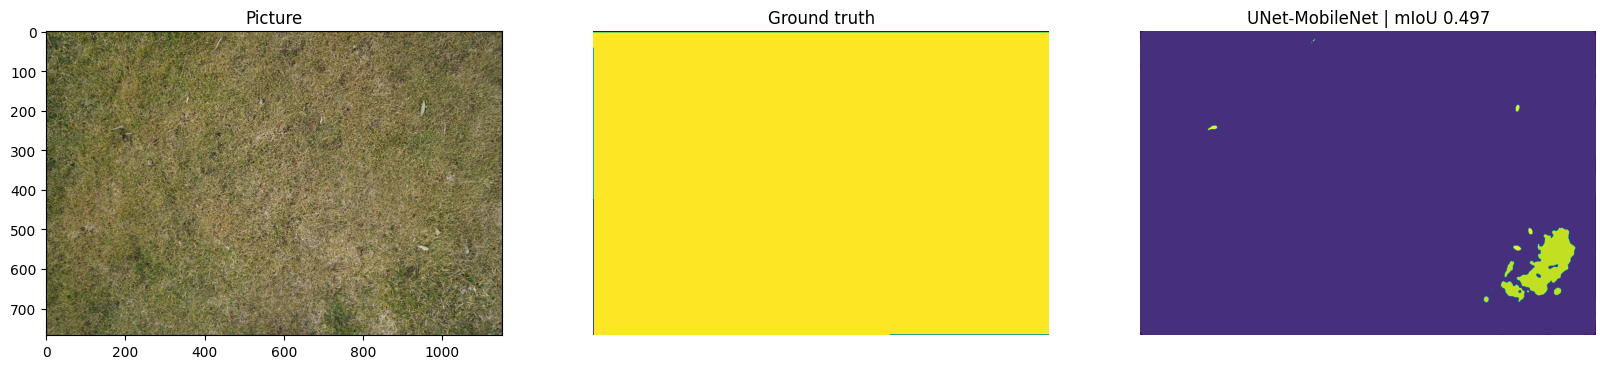

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [23]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.5257528529767587
Test Set Pixel Accuracy 0.9165203518337673
